# Use Soft Actor-Critic with Auto $\alpha$ Tuning to Play LunarLander-v2

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

08:49:53 [INFO] env: <LunarLander<LunarLander-v2>>
08:49:53 [INFO] action_space: Discrete(4)
08:49:53 [INFO] observation_space: Box(-inf, inf, (8,), float32)
08:49:53 [INFO] reward_range: (-inf, inf)
08:49:53 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
08:49:53 [INFO] _max_episode_steps: 1000
08:49:53 [INFO] _elapsed_steps: None
08:49:53 [INFO] id: LunarLander-v2
08:49:53 [INFO] entry_point: gym.envs.box2d:LunarLander
08:49:53 [INFO] reward_threshold: 200
08:49:53 [INFO] nondeterministic: False
08:49:53 [INFO] max_episode_steps: 1000
08:49:53 [INFO] _kwargs: {}
08:49:53 [INFO] _env_name: LunarLander


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SACAgent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        # create alpha
        self.target_entropy = np.log(self.action_n) / 4.
        self.ln_alpha_tensor = torch.zeros(1, requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.ln_alpha_tensor,], lr=3e-4)

        # create actor
        self.actor_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256],
                output_size=self.action_n, output_activator=nn.Softmax(-1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=3e-4)

        # create V critic
        self.v_evaluate_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256])
        self.v_target_net = copy.deepcopy(self.v_evaluate_net)
        self.v_optimizer = optim.Adam(self.v_evaluate_net.parameters(), lr=3e-4)
        self.v_loss = nn.MSELoss()

        # create Q critic
        self.q0_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256], output_size=self.action_n)
        self.q1_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256], output_size=self.action_n)
        self.q0_loss = nn.MSELoss()
        self.q1_loss = nn.MSELoss()
        self.q0_optimizer = optim.Adam(self.q0_net.parameters(), lr=3e-4)
        self.q1_optimizer = optim.Adam(self.q1_net.parameters(), lr=3e-4)

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= 500:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.0025):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(learning_rate * evaluate_param.data
                    + (1 - learning_rate) * target_param.data)

    def learn(self):
        states, actions, rewards, next_states, dones = self.replayer.sample(128)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train alpha
        prob_tensor = self.actor_net(state_tensor)
        ln_prob_tensor = torch.log(prob_tensor.clamp(1e-6, 1))
        neg_entropy_tensor = (prob_tensor * ln_prob_tensor).sum()
        # OR neg_entropy_tensor = torch.xlogy(prob_tensor, prob_tensor).sum()
        grad_tensor = neg_entropy_tensor + self.target_entropy
        alpha_loss_tensor = -self.ln_alpha_tensor * grad_tensor.detach()
        self.alpha_optimizer.zero_grad()
        alpha_loss_tensor.backward()
        self.alpha_optimizer.step()

        # train Q critic
        next_v_tensor = self.v_target_net(next_state_tensor)
        q_target_tensor = reward_tensor.unsqueeze(1) + self.gamma * \
                (1. - done_tensor.unsqueeze(1)) * next_v_tensor

        all_q0_pred_tensor = self.q0_net(state_tensor)
        q0_pred_tensor = torch.gather(all_q0_pred_tensor, 1, action_tensor.unsqueeze(1))
        q0_loss_tensor = self.q0_loss(q0_pred_tensor, q_target_tensor.detach())
        self.q0_optimizer.zero_grad()
        q0_loss_tensor.backward()
        self.q0_optimizer.step()

        all_q1_pred_tensor = self.q1_net(state_tensor)
        q1_pred_tensor = torch.gather(all_q1_pred_tensor, 1, action_tensor.unsqueeze(1))
        q1_loss_tensor = self.q1_loss(q1_pred_tensor, q_target_tensor.detach())
        self.q1_optimizer.zero_grad()
        q1_loss_tensor.backward()
        self.q1_optimizer.step()

        # train V critic
        q0_tensor = self.q0_net(state_tensor)
        q1_tensor = self.q1_net(state_tensor)
        q01_tensor = torch.min(q0_tensor, q1_tensor)
        prob_tensor = self.actor_net(state_tensor)
        ln_prob_tensor = torch.log(prob_tensor.clamp(1e-6, 1.))
        alpha = self.ln_alpha_tensor.exp().detach().item()
        entropic_q01_tensor = prob_tensor * (q01_tensor - alpha * ln_prob_tensor)
        # OR entropic_q01_tensor = prob_tensor * (q01_tensor -
        #         alpha * torch.xlogy(prob_tensor, prob_tensor)
        v_target_tensor = torch.sum(entropic_q01_tensor, dim=-1, keepdim=True)
        v_pred_tensor = self.v_evaluate_net(state_tensor)
        v_loss_tensor = self.v_loss(v_pred_tensor, v_target_tensor.detach())
        self.v_optimizer.zero_grad()
        v_loss_tensor.backward()
        self.v_optimizer.step()

        self.update_net(self.v_target_net, self.v_evaluate_net)

        # train actor
        prob_q_tensor = prob_tensor * (alpha * ln_prob_tensor - q0_tensor)
        actor_loss_tensor = prob_q_tensor.sum(axis=-1).mean()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()


agent = SACAgent(env)

08:49:53 [INFO] ==== train ====
08:49:53 [DEBUG] train episode 0: reward = -119.74, steps = 100
08:49:53 [DEBUG] train episode 1: reward = -53.41, steps = 63
08:49:53 [DEBUG] train episode 2: reward = -136.45, steps = 87
08:49:53 [DEBUG] train episode 3: reward = -326.87, steps = 70
08:49:54 [DEBUG] train episode 4: reward = -117.95, steps = 113
08:49:55 [DEBUG] train episode 5: reward = -336.63, steps = 96
08:49:58 [DEBUG] train episode 6: reward = -181.90, steps = 99
08:50:02 [DEBUG] train episode 7: reward = -145.90, steps = 117
08:50:05 [DEBUG] train episode 8: reward = -310.74, steps = 100
08:50:07 [DEBUG] train episode 9: reward = -144.71, steps = 66
08:50:11 [DEBUG] train episode 10: reward = -2.77, steps = 150
08:50:14 [DEBUG] train episode 11: reward = -162.35, steps = 91
08:50:16 [DEBUG] train episode 12: reward = -315.83, steps = 72
08:50:18 [DEBUG] train episode 13: reward = -447.24, steps = 69
08:50:21 [DEBUG] train episode 14: reward = -351.69, steps = 106
08:50:23 [DEBUG

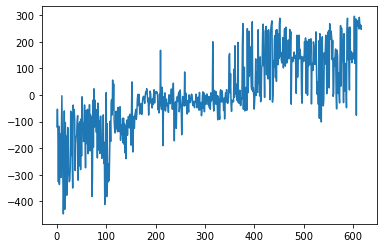

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()